# Application: Stock Price Forecasting



* Goal: Facebook's closing stock price, one day, one month in advance
* Questions: research, math
* See or Meet the data
* Simulation exercise: 
  * Generate data: ARMA components
  * Fit models: python
  * Evaluate model fit: AIC/BIC 
* Form predictions
  * stationary time series
  * model fit, validate with sample splitting
  * predictions 

### Goals
* Convert real-world dataset to stationary time series
* Recognize AR and MA components from ACF/PACF plots
* Fit AR and MA models 
* Evaluate model fit using sample splitting 
* Form predictions with AR/MA models 
* Form confidence intervals around predictions

### General Approach
1. Pose research question *
2. Find data
3. Translate research question to math question *
4. Select an appropriate model
5. Conduct analysis
6. Interpret results 

* Research Question: **Can we predict Facebook’s closing stock price? (one day/one month)**
* Math question: **With Facebook’s historical data, what is the best estimator of the stock price for 1 day, 1 month?**
* Math question: **What is the test-sample mean squared error of each estimate?**

### Dataset: Stock Prices
Data is from Yahoo finance, which maintains a python package to retrieve daily stock prices. 

In [1]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm

df0 = pd.read_csv("meta.csv")
print(df0.head())

   Unnamed: 0       Price           Adj Close               Close  \
0           0      Ticker                META                META   
1           1        Date                 NaN                 NaN   
2           2  2012-05-18   38.02140808105469   38.22999954223633   
3           3  2012-05-21   33.84432601928711  34.029998779296875   
4           4  2012-05-22  30.830860137939453                31.0   

                High                 Low                Open     Volume  
0               META                META                META       META  
1                NaN                 NaN                 NaN        NaN  
2               45.0                38.0   42.04999923706055  573576400  
3  36.65999984741211                33.0  36.529998779296875  168192700  
4  33.59000015258789  30.940000534057617   32.61000061035156  101786600  


### Code:
**Objective:** Cleanup of data
#### Definitions:
- Rows aka Records
- Columns aka Fields
- df aka DataFrame. It is a variable name used to refer that is a DataFrame
    - ie: df_meta is a DataFrame of META stock prices time series
#### Data Cleanup
- The first 2 rows, records 0,1 are not data and must be dropped
- The field named "Price" survives, but the field "Date" is erased
    - Thus the "Price" is renamed as "Date"
- The record numbers are misindexed starting at 2. Caused by the dropping records 0,1
    - Thus the DataFrame is reindexed with df.reset_index()
- The datatypes of all numbers are defaulted to string
    - Thus "Close" field

In [2]:
# Drops or erases the first two rows or records
df0_cleaned = df0.drop([0, 1])
# Renames the "Price" column or field to "Date" and Resets the indexing
df0_cleaned = ((df0_cleaned.rename(columns={"Price": "Date"})).reset_index())
# The old index is dropped
df0_cleaned = df0_cleaned.drop(['index'],axis=1)
df_meta = df0_cleaned.drop(['Unnamed: 0'],axis=1)
# The "Close", "Date" column are converted from string to numeric and datetime respectively
df_meta['Close'] = pd.to_numeric(df_meta['Close'], errors="coerce")
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
print(df_meta.head())

        Date           Adj Close      Close                High  \
0 2012-05-18   38.02140808105469  38.230000                45.0   
1 2012-05-21   33.84432601928711  34.029999   36.65999984741211   
2 2012-05-22  30.830860137939453  31.000000   33.59000015258789   
3 2012-05-23  31.825403213500977  32.000000                32.5   
4 2012-05-24   32.84978485107422  33.029999  33.209999084472656   

                  Low                Open     Volume  
0                38.0   42.04999923706055  573576400  
1                33.0  36.529998779296875  168192700  
2  30.940000534057617   32.61000061035156  101786600  
3  31.360000610351562    31.3700008392334   73600000  
4  31.770000457763672   32.95000076293945   50237200  


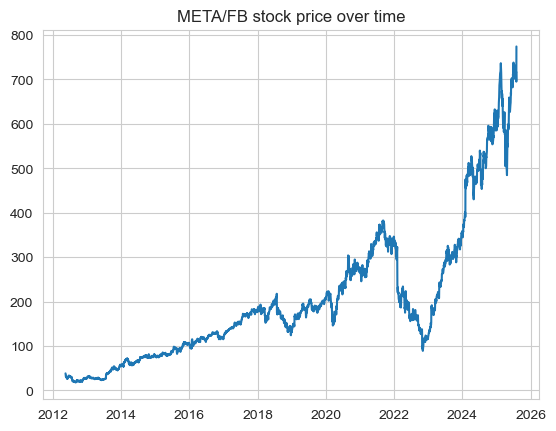

In [3]:
price = df_meta['Close'].values.reshape(-1,1)
date = df_meta['Date'].values.reshape(-1,1)
plt.plot(date, price)
plt.title("META/FB stock price over time")
plt.show()

### General Analysis Steps 

1. Do we need to scale the data? **Yes**, looks like the degree of variation is not constant over time
2. Fit (non)linear trend to the data? **Yes**, looks like there's a trend to the data 
3. Fit seasonal components? IDK yet
4. Fit external regressors? IDK yet
5. Fit AR/MA model? TBD

### Transforming data
- The variance of the data is not periodic. It has quite big changes. ---> **No stationarity can be assumed.**
- We can correct by taking a log transformation of the data - now, the variance looks more consistent over the time series. 

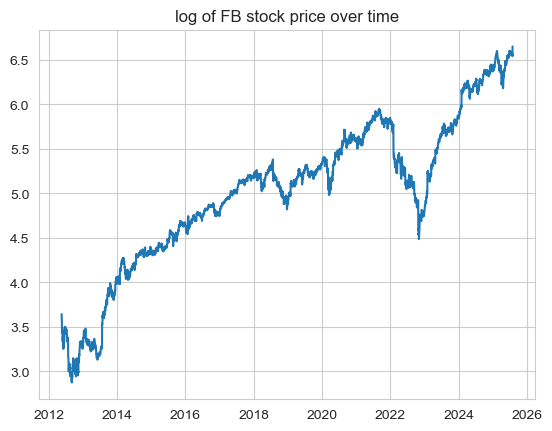

In [4]:
# Applying log transformation
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of FB stock price over time")
plt.show()

#### Information Criteria

**Idea:** find a balance between model fit and complexity. 

**AIC** (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$ 

**BIC** (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$ 

$k$ is the model complexity (degrees of freedom used up); 
$n$ is the number of elements. 

A good practice is to select a model that minimizes both of these criteria; when they disagree, turn to another approach like out-of-sample validation. 

In [22]:
# Example here about how to find; what my assumption is behind this 
from scipy.stats import norm 
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)

def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and 
  the residuals of the model. Assumes residuals are distributed 
  Gaussian with unknown variance. 
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

def q_regresion(x,y,degree=1):
  model = Pipeline([
    ('poly', PolynomialFeatures(degree=degree)),
    ('linear', LinearRegression())
  ])
  model.fit(x, y)
  y_hat= model.predict(x)
  coefficients = model.named_steps['linear'].coef_
  intercept = model.named_steps['linear'].intercept_
  return coefficients, intercept, y_hat

def grid_search_ARIMA(data, AR_range, MA_range, verbose=False, warning=False):
    '''
    Determines automatically the AR MA parameters of the data.
    it will determine up to the top limits of AR MA as received in AR_range and MA_range.
    :param data: Time Series data
    :param AR_range: Number of AR terms to consider
    :param MA_range: Number of MA terms to consider
    :param verbose: Show calculation details
    :param warning: Show runtime warnings
    :return:    min_aic_index (AR, MA, ARMA) number of coefficients to consider
                max_aic_index (AR, MA, ARMA) number of coefficients to consider
                aic_matrix, bic_matrix
    '''
    if warning == False:
        warnings.filterwarnings("ignore")
    print("> starting grid_search_ARIMA")
    min_aic = np.inf
    min_bic = np.inf
    min_aic_index = None
    min_bic_index = None
    aic_matrix = np.zeros((len(AR_range), len(MA_range)))
    bic_matrix = np.zeros((len(AR_range), len(MA_range)))
    for AR_order in AR_range:
        for MA_order in MA_range:
            arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
            aic_matrix[AR_order, MA_order] = arma.aic
            bic_matrix[AR_order, MA_order] = arma.bic
            if arma.aic < min_aic:
                min_aic = arma.aic
                min_aic_index = (AR_order, 0, MA_order)
            if arma.bic < min_bic:
                min_bic = arma.bic
                min_bic_index = (AR_order, 0, MA_order)
    if verbose:
        print("Minimizing AIC order: ", min_aic_index)
        print("Minimizing BIC order: ", min_bic_index)
        print("matrix of AIC", aic_matrix)
        print("Matrix of BIC", bic_matrix)
    print("... end grid_search_ARIMA")
    return min_aic_index, min_bic_index, aic_matrix, bic_matrix

def quick_summary_ARIMA(data, min_aic_index, min_bic_index):
    if min_aic_index == min_bic_index:
        arma = ARIMA(data, order=min_bic_index).fit()
        print(arma.summary())
        arma_predictions = arma.predict()
        arma_residuals = data - arma_predictions
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].plot(data, label='ARMA time series = original data')
        axs[0].plot(arma_predictions, 'r', label='fitted line')
        axs[0].set_title("ARMA series, predictions & Rsiduals")
        axs[1].plot(data[:20], label='original data')
        axs[1].plot(arma_predictions[:20], label='predicted data')
        axs[1].legend()
        axs[1].set_title("ARMA series & predictions")
        fig.show()
        print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
        print("MSE with selected model:", np.mean(arma_residuals ** 2))
    else:
        print("AIC, BIC do not agree.")


### Start with a linear model: 

Linear fit:  [[0.         0.00080627]] [3.67793334]
Cuadratic fit:  [[ 0.00000000e+00  1.41287014e-03 -1.82819686e-07]] [3.342587]
Cubic fit:  [[ 0.00000000e+00  3.25072349e-03 -1.56778826e-06  2.78273774e-10]] [2.83480342]


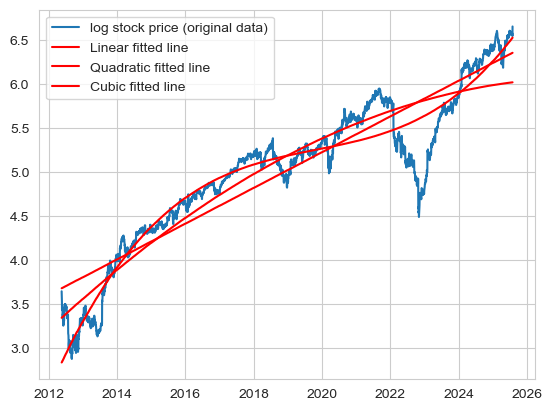

In [23]:
index = df_meta.index.values.reshape(-1,1)

coefficients,intercept, y1_hat = q_regresion(index, log_price,degree=1)
print("Linear fit: ",coefficients,intercept ) # To print the coefficient estimate of the series.
coefficients,intercept, y2_hat = q_regresion(index, log_price,degree=2)
print("Cuadratic fit: ",coefficients,intercept ) # To print the coefficient estimate of the series.
coefficients,intercept, y3_hat = q_regresion(index, log_price,degree=3)
print("Cubic fit: ",coefficients,intercept ) # To print the coefficient estimate of the series.

plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, y1_hat, 'r', label='Linear fitted line')
plt.plot(date, y2_hat, 'r', label='Quadratic fitted line')
plt.plot(date, y3_hat, 'r', label='Cubic fitted line')
plt.legend()
plt.show()

### After linear fit, it seems like a higher order model is needed

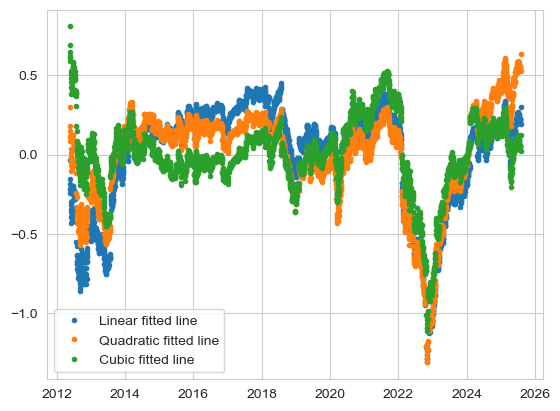

In [7]:
## After linear fit, it seems like a higher order model is needed
from sklearn import linear_model

linear_residuals = log_price - y1_hat
quadratic_residuals = log_price - y2_hat
cubic_residuals = log_price - y3_hat

plt.plot(date, linear_residuals, '.', label='Linear fitted line')
plt.plot(date, quadratic_residuals, '.', label='Quadratic fitted line')
plt.plot(date, cubic_residuals, '.', label='Cubic fitted line')
plt.legend()
plt.show()

In [8]:
print("MSE with linear fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, linear_residuals))
print("BIC:", evaluate_BIC(1, linear_residuals))
print("MSE with quadratic fit:", np.mean((quadratic_residuals)**2))
print("AIC:", evaluate_AIC(1, quadratic_residuals))
print("BIC:", evaluate_BIC(1, quadratic_residuals))
print("MSE with cubic fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, cubic_residuals))
print("BIC:", evaluate_BIC(1, cubic_residuals))

MSE with linear fit: 0.11602127345740579
AIC: 2271.848678576916
BIC: 2277.956097388636
MSE with quadratic fit: 0.09348914469090151
AIC: 1555.182862714401
BIC: 1561.290281526121
MSE with cubic fit: 0.11602127345740579
AIC: -115.0568807577049
BIC: -108.94946194598492


### This looks like a satisfactory model for the trend 

## Examine ACF/PACF

This tells us about the existence of periodic components, or AR/MA models. 

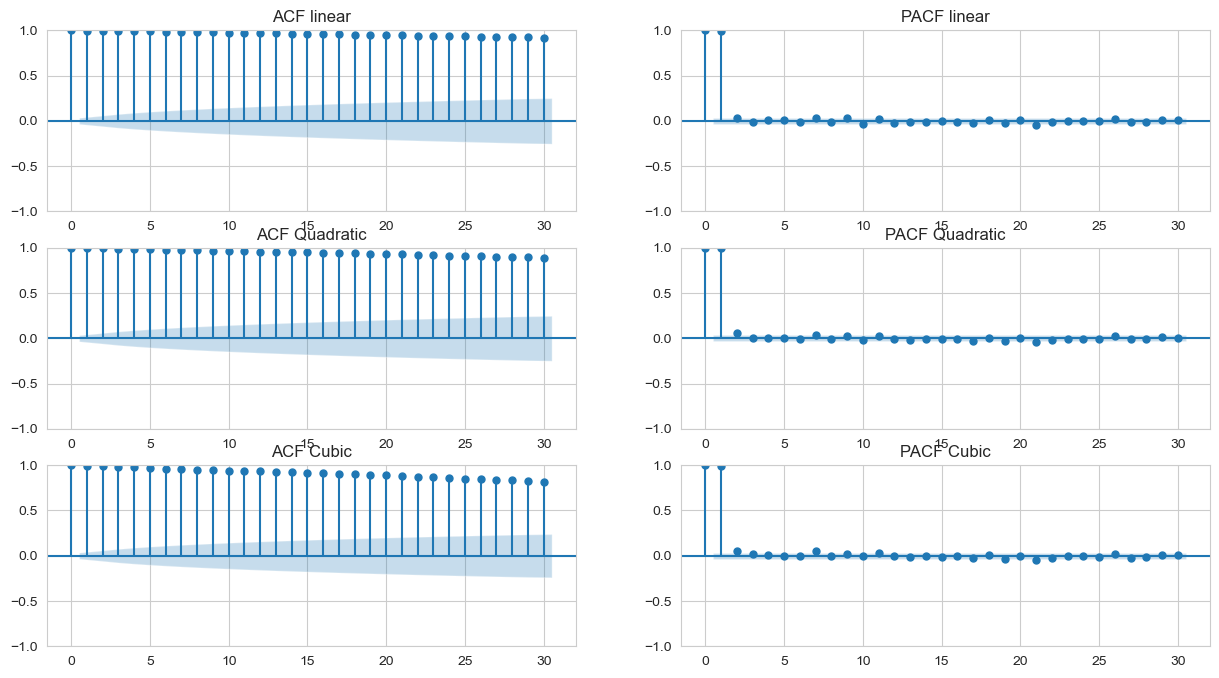

In [9]:
import statsmodels.api as sm
fig, axs = plt.subplots(3, 2, figsize = (15,8))
sm.graphics.tsa.plot_acf(linear_residuals, lags=30, ax=axs[0,0], title="ACF linear")
sm.graphics.tsa.plot_pacf(linear_residuals, lags=30, ax=axs[0,1], title="PACF linear")
sm.graphics.tsa.plot_acf(quadratic_residuals, lags=30, ax=axs[1,0], title="ACF Quadratic")
sm.graphics.tsa.plot_pacf(quadratic_residuals, lags=30, ax=axs[1,1], title="PACF Quadratic")
sm.graphics.tsa.plot_acf(cubic_residuals, lags=30, ax=axs[2,0], title="ACF Cubic")
sm.graphics.tsa.plot_pacf(cubic_residuals, lags=30, ax=axs[2,1], title="PACF Cubic")
plt.show()

By simple observation the ACF, PACF do not hint which one is better. Thus Relying on the:
- MSE with quadratic fit: 0.09348914469090151
- AIC: 1555.182862714401
- BIC: 1561.290281526121

Choosing the quadratic model sounds reasonable.

In [10]:
min_aic_index1, min_bic_index1, _, _ = grid_search_ARIMA(linear_residuals, range(4), range(4), verbose=True)
min_aic_index2, min_bic_index2, _, _ = grid_search_ARIMA(quadratic_residuals, range(4), range(4), verbose=True)
min_aic_index3, min_bic_index3, _, _ = grid_search_ARIMA(cubic_residuals, range(4), range(4), verbose=True)

> starting grid_search_ARIMA
Minimizing AIC order:  (1, 0, 0)
Minimizing BIC order:  (1, 0, 0)
matrix of AIC [[  2273.84868072  -2004.0173312   -5190.36926384  -7477.65746734]
 [-15011.63719526 -15010.90823049 -15009.17902717 -15008.1411737 ]
 [-15011.02151982 -15009.13993454 -15006.96942068 -15005.80723493]
 [-15009.24828064 -15007.41553837 -15005.37167747 -15003.5689845 ]]
Matrix of BIC [[  2286.06351834  -1985.69507476  -5165.9395886   -7447.12037329]
 [-14993.31493883 -14986.47855524 -14978.64193311 -14971.49666083]
 [-14986.59184457 -14978.60284048 -14970.32490781 -14963.05530325]
 [-14978.71118658 -14970.7710255  -14962.61974579 -14954.709634  ]]
... end grid_search_ARIMA
> starting grid_search_ARIMA
Minimizing AIC order:  (1, 0, 0)
Minimizing BIC order:  (1, 0, 0)
matrix of AIC [[  1557.18286542  -2680.89112047  -5779.69835211  -7982.24232111]
 [-15009.70069416 -15008.85954624 -15007.16941165 -15006.048864  ]
 [-15009.00300796 -15007.19262655 -15005.02511795 -15003.84172867]
 [-

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3319
Model:                 ARIMA(1, 0, 0)   Log Likelihood                7508.819
Date:                Thu, 21 Aug 2025   AIC                         -15011.637
Time:                        11:38:02   BIC                         -14993.315
Sample:                             0   HQIC                        -15005.081
                               - 3319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.692e-08      0.185   3.62e-07      1.000      -0.362       0.362
ar.L1          0.9974      0.001    951.756      0.000       0.995       0.999
sigma2         0.0006   4.59e-06    138.106      0.0

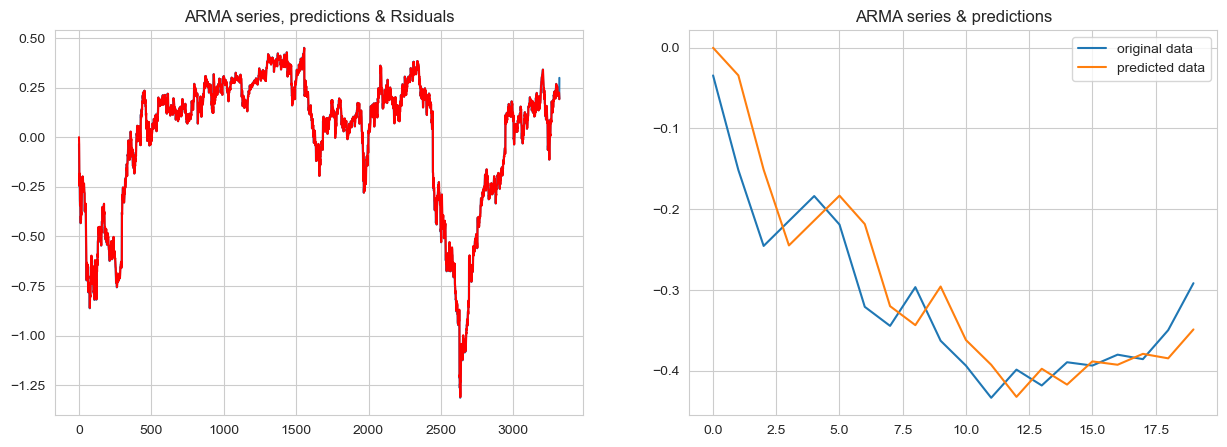

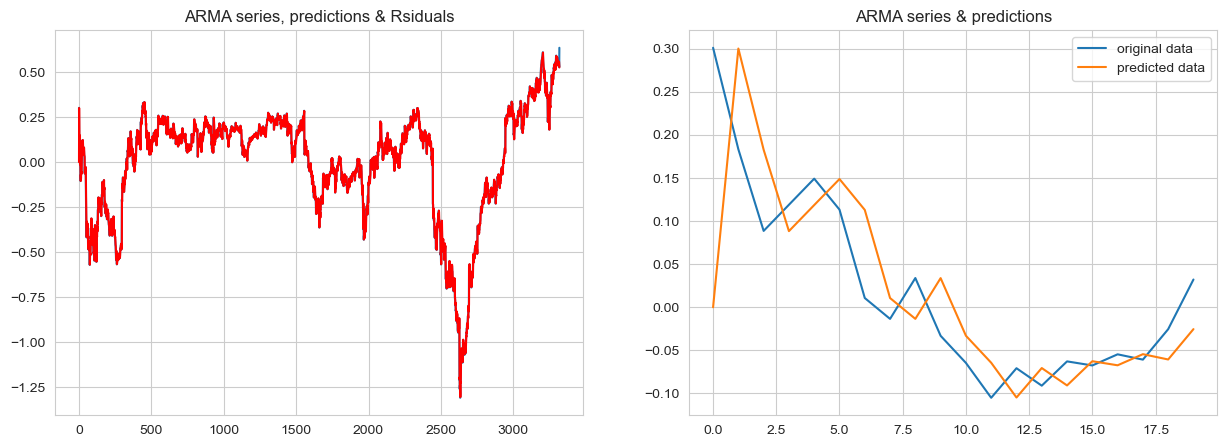

In [11]:
quick_summary_ARIMA(linear_residuals,min_aic_index1,min_bic_index1)
quick_summary_ARIMA(quadratic_residuals,min_aic_index2,min_bic_index2)

## Interpretation: 
After taking a log transformation of the data, and removing a quadratic trend, there's a pattern in the ACF/PACF plots we didn't see in the last video. 

Strong first term in PACF, exponentially decaying ACF.
From lecture, you may recognize this pattern as evidence of an AR(1) component.


It's important to model these terms, because AR/MA can change the error structure, if analysis of coefficients is important. It can also change how we make forecasts, and our confidence bands on those forecasts. 

But how do we deal with this? To figure out, let's work through an example with simulated data first.

### Evaluate with Test Set

Here, we see how well this predicts future values; we set an arbitrary value of 20% of the series. In practice, you would likely use rolling windows to assess the performance more credibly, since 20% of the series can actually be much further than the model predicts. 

An illustration of rolling windows: for $t = 1, \dots, 100$, train a model on steps $t = 1, \dots, 20$, then predict on $t = 21, \dots, 40$. Then train the model on $t = 1, \dots, 40$ and predict on $t = 41, \dots, 60$, and so on.

In [12]:
train_test_split = int(len(price) * 0.8)
train_price, test_price = quadratic_residuals[:train_test_split], quadratic_residuals[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert(len(train_date) + len(test_date) == len(date))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2655
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5982.981
Date:                Thu, 21 Aug 2025   AIC                         -11959.963
Time:                        11:38:03   BIC                         -11942.310
Sample:                             0   HQIC                        -11953.573
                               - 2655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0128      0.228     -0.056      0.955      -0.459       0.433
ar.L1          0.9978      0.001    725.515      0.000       0.995       1.001
sigma2         0.0006    5.1e-06    126.285      0.0

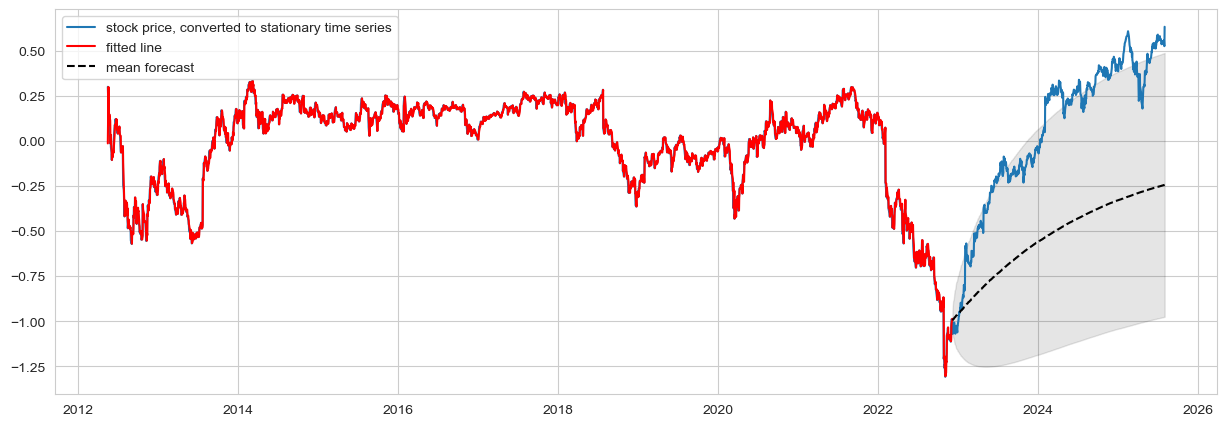

In [13]:
## First, let's see how this does with the AIC selected values. 
arma = ARIMA(train_price, order=min_aic_index2).fit()
print(arma.summary())
fcast = arma.get_forecast(len(test_price)).summary_frame()
forecast_means = fcast['mean'].values.reshape(-1,1)
arma_predictions = arma.predict()
predicted_values = arma_predictions.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(date, quadratic_residuals, label='stock price, converted to stationary time series')
ax.plot(train_date, predicted_values, 'r', label='fitted line')
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2655
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5982.981
Date:                Thu, 21 Aug 2025   AIC                         -11959.963
Time:                        11:38:03   BIC                         -11942.310
Sample:                             0   HQIC                        -11953.573
                               - 2655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0128      0.228     -0.056      0.955      -0.459       0.433
ar.L1          0.9978      0.001    725.515      0.000       0.995       1.001
sigma2         0.0006    5.1e-06    126.285      0.0

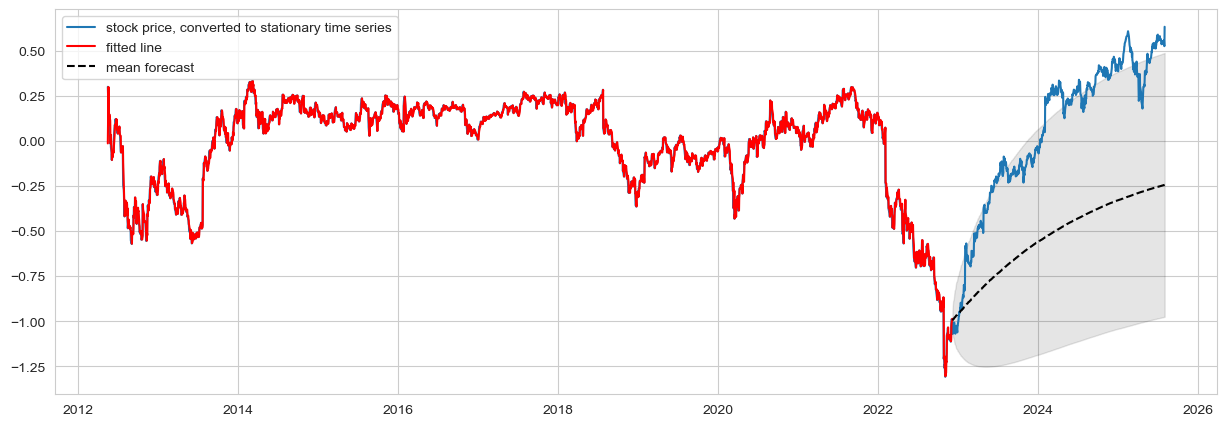

In [14]:
## Now, let's see how this does with the BIC selected values. 
arma = ARIMA(train_price, order=min_bic_index2).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, quadratic_residuals, label='stock price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
test_set_mse = np.mean((forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();
print("Test set mean squared error: ", test_set_mse)

### Interpretation:
The BIC selected value has a lower test-set mean squared error. 
Using daily values, the best predictor of stock price uses the AR(1) model, and has a coefficient of 0.9923. That is, the best predictor of tomorrow's stock price, is 0.9923 times today's stock price (after taking logs and removing the quadratic trend)

Turns out, the conclusion we get from looking at the ACF/PACF plots was more accurate than just doing a grid search over these values. 

### Extension: Monthly Predictions

If you're interested in long-range forecasts, it might be better to convert the time series to monthly values. 

This loses lots of rich variation, but avoids the problem where predictions one month away will have converged to the mean of the series. 

Here, we show how to manipulate the time series to do this alternate procedure. 

We follow the same steps: convert to stationary, model the AR/MA components, and then form predictions.

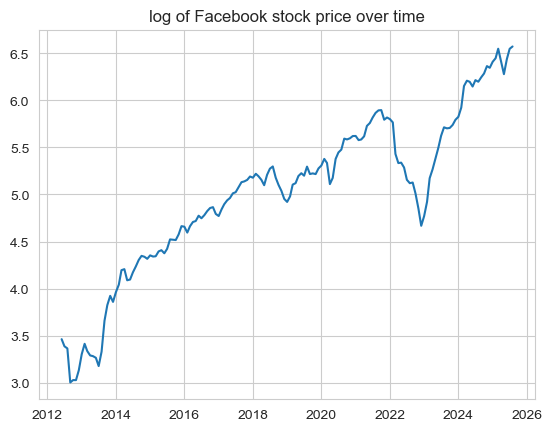

In [24]:
#collapsed = (df_meta['Date'].Grouper(freq ='M')).mean()
#collapsed = df_meta.groupby(pd.Grouper(key='Date', freq='M'))
df1 = df_meta.resample('M',on='Date')['Close'].mean()
#df2 = df_meta.resample('M',on='Date')['High'].mean()
#print(df2.head())
collapsed = df1.reset_index()
month_date = collapsed['Date'].dt.date.values.reshape(-1,1)
month_price = collapsed['Close'].values.reshape(-1,1)
month_log_price = np.log(month_price)
plt.plot(month_date, month_log_price)
plt.title("log of Facebook stock price over time")
plt.show()

[[ 2.94479741e-02 -7.91500563e-05]]


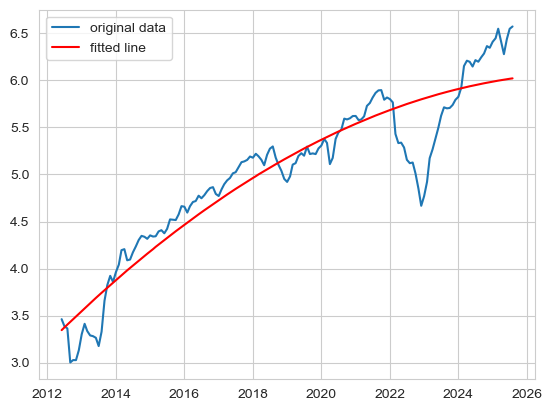

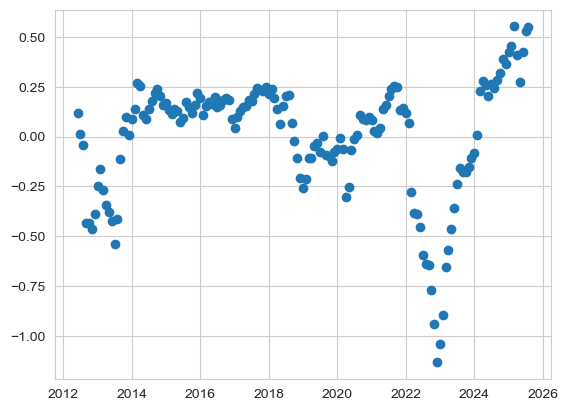

MSE with quadratic fit: 0.09116469230021676


In [17]:
clf = linear_model.LinearRegression()
index = collapsed.reset_index().index.values.reshape(-1,1)
new_x = np.hstack((index, index **2))
clf.fit(new_x, month_log_price)
print(clf.coef_) # To print the coefficient estimate of the series. 
month_quad_prediction = clf.predict(new_x)
plt.plot(month_date, month_log_price, label='original data')
plt.plot(month_date, month_quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
month_quad_residuals = month_log_price - month_quad_prediction
plt.plot(month_date, month_quad_residuals, 'o')
plt.show();
print("MSE with quadratic fit:", np.mean((month_quad_residuals)**2))

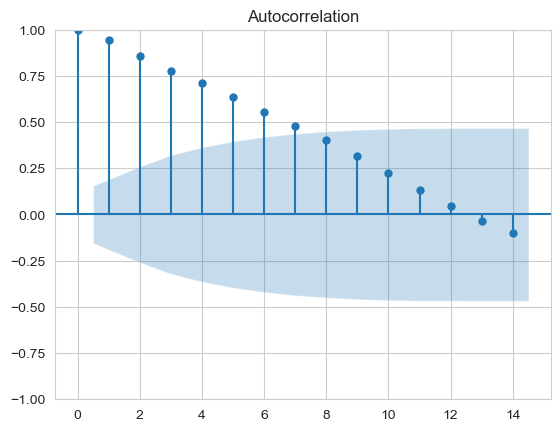

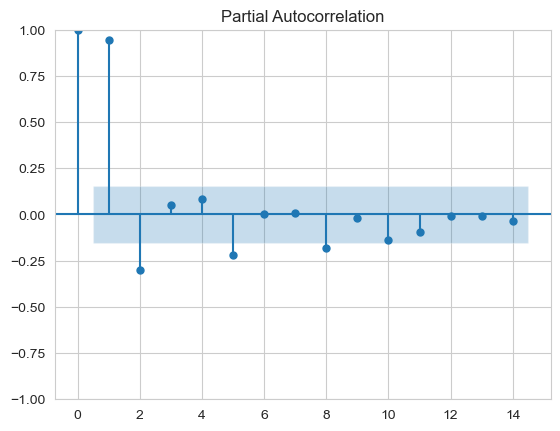

In [18]:
sm.graphics.tsa.plot_acf(month_quad_residuals, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(month_quad_residuals, lags=14)
plt.show()

In [19]:
month_train_test = int(0.8 * len(month_date))
month_train, month_test = month_quad_residuals[:month_train_test], month_quad_residuals[month_train_test:]
month_date_train, month_date_test = month_date[:month_train_test], month_date[month_train_test:]

In [20]:
min_aic_index, min_bic_index, *other = grid_search_ARIMA(month_quad_residuals, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
  arma = ARIMA(month_quad_residuals, order=min_bic_index).fit()
  print(arma.summary())
  arma_predictions = arma.predict()
  arma_residuals = month_quad_residuals.reshape(arma_predictions.shape) - arma_predictions
  arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
  plt.plot(month_quad_residuals, label='Residuals from fitted quadratic line')
  plt.plot(arma_predictions, 'r', label='fitted ARMA process')
  plt.legend()
  plt.show()
  plt.plot(arma_residuals, 'o')
  plt.show()
  print("Automatic selection finds model with AR {0}, MA {2}".format(*min_aic_index))
  print("MSE with selected model:", np.mean(arma_residuals**2))
else:
  print("AIC, BIC do not agree.")

> starting grid_search_ARIMA
Minimizing AIC order:  (3, 0, 2)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[  74.40352486  -99.3492368  -224.5080661  -257.20385011]
 [-308.51126958 -329.12331588 -330.65219307 -331.80955186]
 [-330.78673386 -329.41118701 -332.46996362 -331.84197645]
 [-329.54319882 -327.54789974 -335.82383468 -331.07450811]]
Matrix of BIC [[  80.54133327  -90.14252419 -212.23244929 -241.8593291 ]
 [-299.30455697 -316.84769908 -315.30767206 -313.39612665]
 [-318.51111706 -314.066666   -314.05653841 -310.35964703]
 [-314.19867781 -309.13447453 -314.34150526 -306.52327449]]
... end grid_search_ARIMA
AIC, BIC do not agree.


Test set mean squared error:  0.4655104377908804


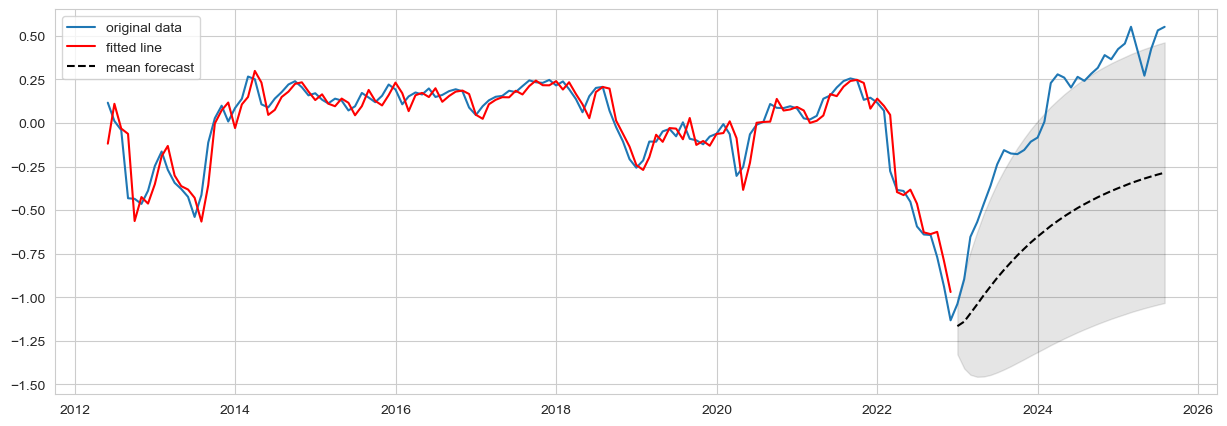

In [21]:
arma = ARIMA(month_train, order=min_bic_index).fit()
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(month_test)).summary_frame()

arma_predictions = arma.predict()
ax.plot(month_date, month_quad_residuals, label='original data')
predicted_values = arma_predictions.reshape(-1,1)
ax.plot(month_date_train, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1,1)
ax.plot(month_date_test, forecast_means, 'k--', label='mean forecast')
ax.fill_between(month_date_test.flatten(), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
plt.legend();

test_set_mse = np.mean((forecast_means.reshape(month_test.shape) - month_test)**2)
print("Test set mean squared error: ", test_set_mse)